In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import numba as nb
from scipy.interpolate import interp2d
from scipy.interpolate import RegularGridInterpolator
import scipy

In [2]:
A_mean = np.load('A_mean_222.npy')
ps = np.load('ps_222.npy')
AA_s = np.load('AA_record_222.npy')
matrix_s = np.load('matrix_record_222.npy')
diversity_record = np.load('diversity_record_222.npy')
fluc_record = np.load('fluc_record_222.npy')
div_mean = np.load('div_mean_222.npy')
fluc_mean = np.load('fluc_mean_222.npy')
print(np.shape(diversity_record))
ystep = 21   # A_mean 的步数
pstep = 14
num_sim = 200  # A_mean 的步数

(14, 21, 200)


In [3]:
print(np.shape(div_mean))
print(np.shape(ps))
print(np.shape(A_mean))
print(np.shape(AA_s))


(14, 21)
(14,)
(21,)
(14, 21, 200, 40, 40)


In [4]:
def plot_3d_matrix(matrix, x_in, y_in):
    rows, cols = matrix.shape

    # 创建 X 和 Y 坐标
    
    #X, Y = np.meshgrid(np.arange(cols), np.arange(rows))
    X, Y = np.meshgrid(x_in, y_in)

    # 绘制三维图
    fig = plt.figure(figsize=(18, 6))
    ax = fig.add_subplot(111, projection='3d')

    # 使用矩阵值作为 Z 坐标
    Z = matrix

    # 绘制曲面
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')

    # 添加颜色条
    fig.colorbar(surf, shrink=0.5, aspect=10)

    # 设置标题和标签
    ax.set_title('3D Matrix Visualization')
    A_mean_p = A_mean
    ps_p = ps
    A_mean_p= np.around(A_mean_p,3)
    ps_p = np.around(ps_p,3)
    ax.set_yticks(A_mean_p[::5])
    ax.set_xticks(ps_p[:-10])
    ax.set_xlabel('p')
    ax.set_ylabel('Interaction')
    ax.set_zlabel('Matrix Value')

    plt.show()

In [5]:
def plot_3d_matrix_ori(matrix):
    rows, cols = matrix.shape

    # 创建 X 和 Y 坐标
    
    X, Y = np.meshgrid(np.arange(cols), np.arange(rows))
    #X, Y = np.meshgrid(ps, A_mean)

    # 绘制三维图
    fig = plt.figure(figsize=(18, 6))
    ax = fig.add_subplot(111, projection='3d')

    # 使用矩阵值作为 Z 坐标
    Z = matrix

    # 绘制曲面
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')

    # 添加颜色条
    fig.colorbar(surf, shrink=0.5, aspect=10)
    A_mean_p = A_mean
    ps_p = ps
    A_mean_p = np.around(A_mean_p,3)
    ps_p = np.around(ps_p,3)
    # 设置标题和标签
    ax.set_title('3D Matrix Visualization')
    ax.set_yticks(np.arange(0,ystep,5),A_mean_p[::5])
    ax.set_xticks(np.arange(0,pstep,5),ps_p[::5])
    ax.set_xlabel('p')
    ax.set_ylabel('Interaction')
    ax.set_zlabel('Matrix Value')

    plt.show()

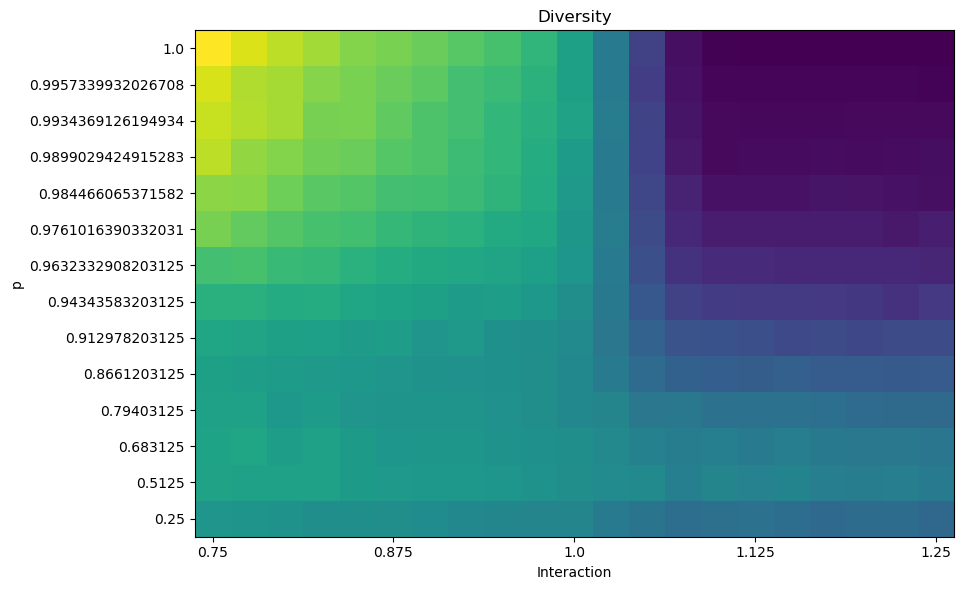

In [6]:
plt.figure(figsize=(30, 6))
plt.imshow(div_mean, origin='lower')
plt.xticks(np.arange(0,ystep,5),A_mean[::5])
plt.yticks(np.arange(0,pstep,1),ps)
plt.xlabel("Interaction")  # 设置横轴标签
plt.ylabel("p")  # 设置纵轴标签
plt.title("Diversity")   # 设置标题（可选）
plt.tight_layout()
plt.show()

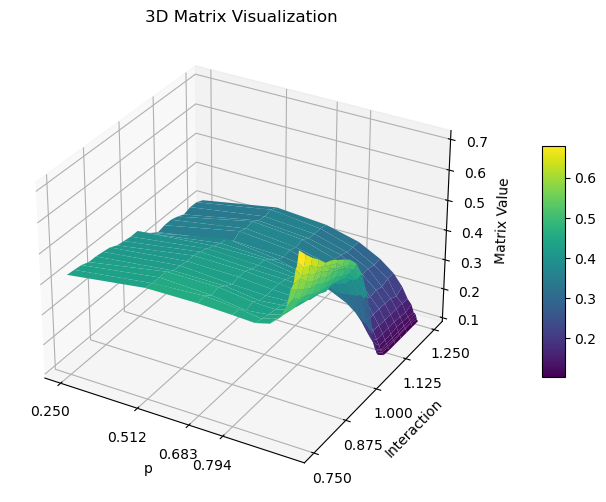

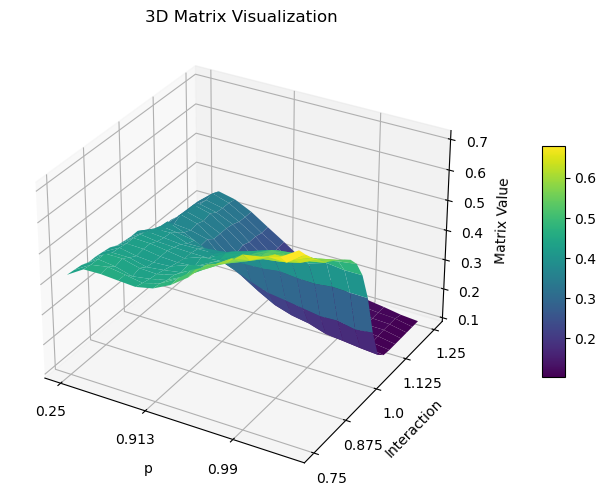

In [7]:
plot_3d_matrix(div_mean.T, ps, A_mean)
plot_3d_matrix_ori(div_mean.T)

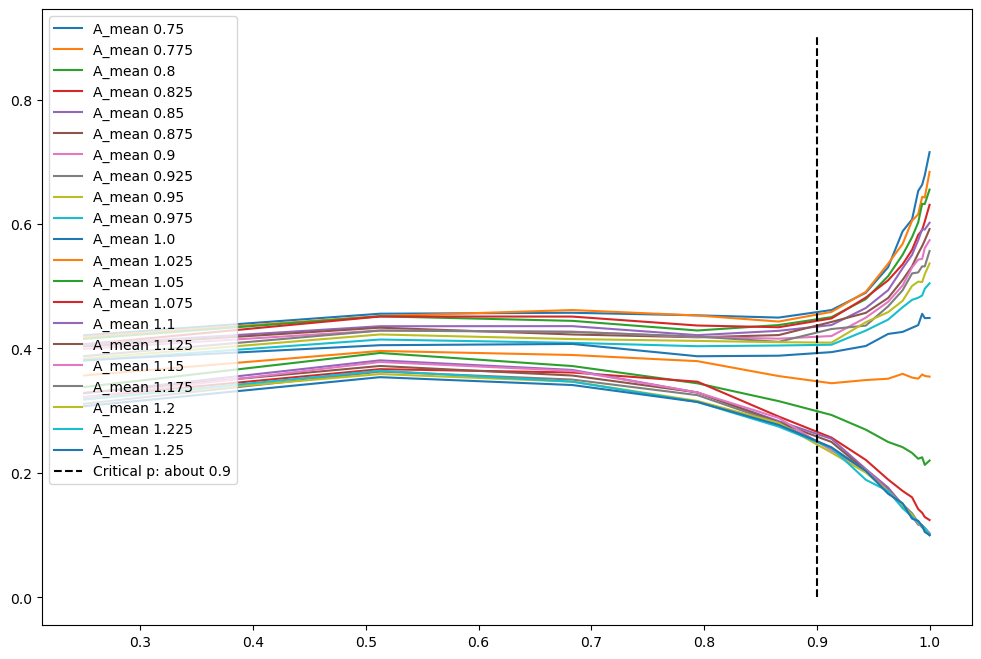

In [8]:
plt.figure(figsize=(12, 8))
for i in range(ystep):
    plt.plot(ps[:],div_mean[:,i],label=f"A_mean {A_mean[i]}")

xxx= np.ones(10)*0.9
yyy= np.arange(10)*0.1
plt.plot(xxx,yyy,linestyle='--', color = 'black',label=f"Critical p: about {0.9}")
plt.legend(loc='upper left')
plt.show()

In [9]:
#对存活率函数做插值并检验
f2 = RegularGridInterpolator((ps, A_mean), div_mean, bounds_error=False, fill_value=None)
test_points_p = np.linspace(0.25,1,100)
test_points_a = np.linspace(0.7,1.3,100)
test_points = np.zeros((10000,2))
for i in range(100):
    for j in range(100):
        u = i*100+j
        test_points[u,0] = test_points_p[i]
        test_points[u,1] = test_points_a[j]


pri = f2(test_points)
pri_2d = np.zeros((100,100))

for i in range(100):
    for j in range(100):
        u = i*100+j
        pri_2d[i,j] = pri[u]


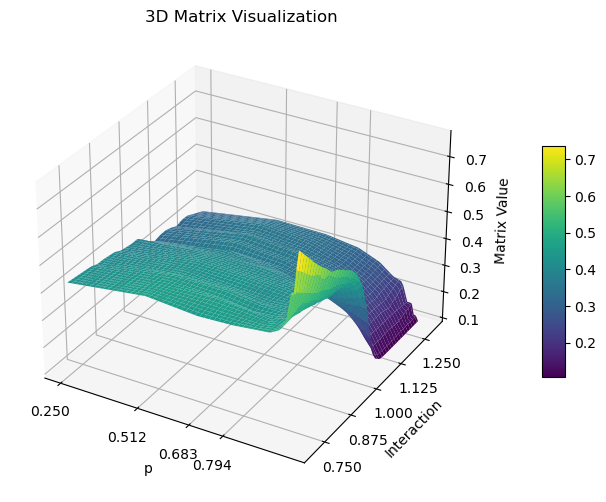

In [10]:
plot_3d_matrix(pri_2d.T, test_points_p, test_points_a)

In [11]:
#计算均值并预测
AA_mean = np.zeros((14,21,200))
pp = np.zeros((14,21,200))
div_pri = np.zeros((14,21,200))

#统计值: 模块内的连接数，模块外的连接数，预测p；右上角所有连接的值，预测a_mean

nodes_per_module = [40 // 4] * 4
for i in range(40 % 4):
    nodes_per_module[i] += 1

module_node_list = []
start = 0
for size in nodes_per_module:
    module_node_list.append(list(range(start, start + size)))
    start += size


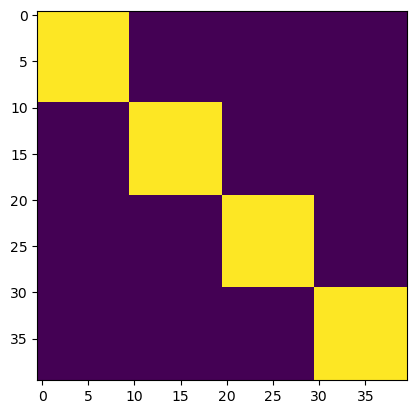

In [12]:
testm = np.zeros((40,40))
for i in range(40):
    for j in range(40):
        testm[i,j] = any(i in module and j in module for module in module_node_list)

plt.imshow(testm)

In [13]:
@jit(nopython=True)
def comp(matrix, AA):
    k_in =0
    k_out=0
    suma =0
    for m in range(40):
        for n in range(m+1, 40):
            same= testm[m,n]
            if same:
                if matrix[n,m] == 1:
                    k_in +=1
                    suma +=AA[n,m]
            else:
                if matrix[n,m] == 1:
                    k_out +=1
                    suma +=AA[n,m]
    p1= 10/13*(1-3*k_out/600) + 3/13*k_in/180
    AA_mean1 = suma/(k_in+k_out)
    return p1, AA_mean1

In [14]:
for i in range(pstep):
    for j in range(ystep):
        for k in range(num_sim):
            p1, A1 =  comp(matrix_s[i,j,k], AA_s[i,j,k])
            pp[i,j,k] =p1
            AA_mean[i,j,k] =A1
                         

0.2495335775335775


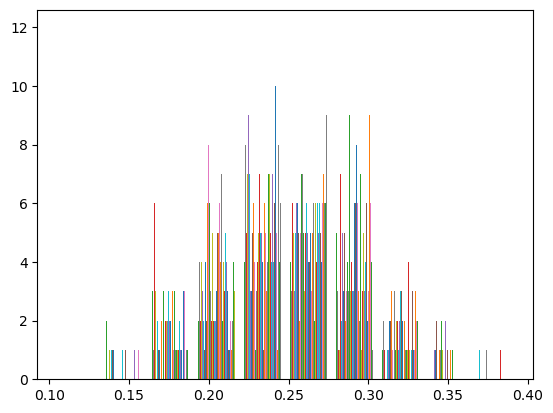

In [15]:
plt.hist(pp[0])
print(np.mean(pp[0]))

1.0 0.10384615384615381


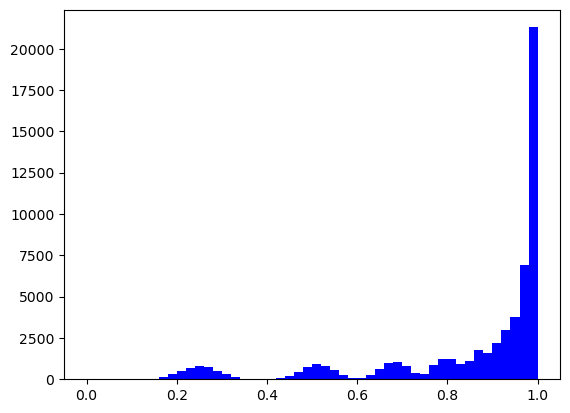

In [16]:

pp_f = pp.flatten()
AA_mean_f=AA_mean.flatten()
diversity_record_f = diversity_record.flatten()
plt.hist(pp_f,bins=50, range=(0,1.0), alpha=1, color='b')
print(np.max(pp_f), np.min(pp_f))


(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.810e+02, 2.509e+03, 1.000e+01, 0.000e+00, 8.500e+01,
        2.624e+03, 9.100e+01, 0.000e+00, 2.000e+01, 2.454e+03, 3.260e+02,
        0.000e+00, 2.000e+00, 1.992e+03, 8.060e+02, 0.000e+00, 1.000e+00,
        1.376e+03, 1.420e+03, 3.000e+00, 0.000e+00, 8.400e+02, 1.953e+03,
        7.000e+00, 0.000e+00, 4.190e+02, 2.334e+03, 4.700e+01, 0.000e+00,
        1.550e+02, 2.479e+03, 1.660e+02, 0.000e+00, 6.000e+01, 2.291e+03,
        4.490e+02, 0.000e+00, 1.500e+01, 1.943e+03, 8.420e+02, 0.000e+00,
        3.000e+00, 1.398e+03, 1.395e+03, 4.000e+00, 4.000e+00, 8.950e+02,
        1.869e+03, 3.200e+01, 2.000e+00, 5.010e+02, 2.212e+03, 8.500e+01,
        0.000e+00, 2.460e+02, 2.296e+03, 2.580e+02, 0.000e+00, 1.130e+02,
        2.168e+03, 5.190e+02, 0.000e+00, 5.000e+01, 1.805e+03, 9.420e+02,
        3.000e+00, 1.800e+01, 1.410e+03, 1.351e+03, 2.100e+01, 8.000e+00,
        9.250e+02, 1.817e+03, 5.000e+0

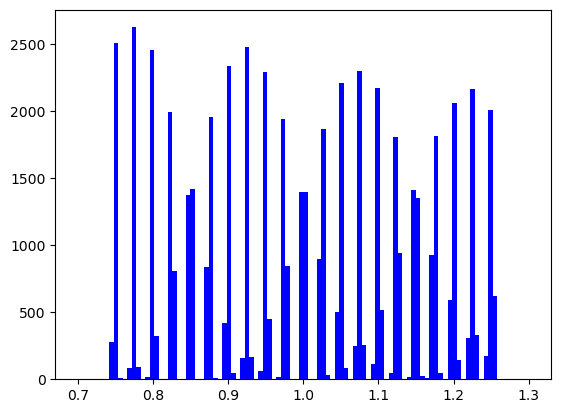

In [17]:
plt.hist(AA_mean_f, bins=100, range=(0.7,1.3), alpha=1, color='b')

In [18]:

points = np.zeros((58800,2))
for i in range(58800):
    points[i,0] = pp_f[i]
    points[i,1] = AA_mean_f[i]
print(np.shape(points))
div_pri_f = f2(points)

(58800, 2)


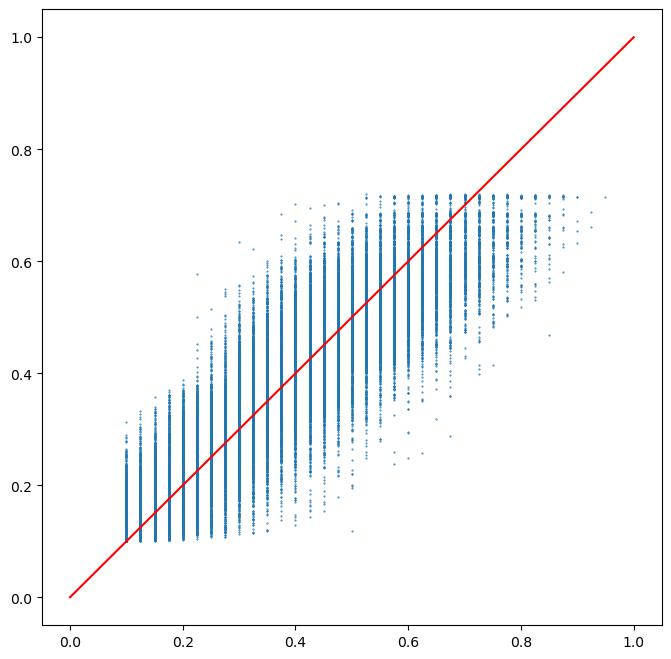

In [19]:
plt.figure(figsize= (8,8))
plt.scatter(diversity_record_f, div_pri_f, s= 0.2)
tes = np.linspace(0,1,100)
plt.plot(tes, tes, color = 'red')

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 6.953e+03, 0.000e+00,
        1.532e+03, 0.000e+00, 0.000e+00, 1.737e+03, 0.000e+00, 1.388e+03,
        0.000e+00, 0.000e+00, 1.535e+03, 0.000e+00, 1.570e+03, 0.000e+00,
        0.000e+00, 1.564e+03, 0.000e+00, 1.745e+03, 0.000e+00, 0.000e+00,
        2.173e+03, 0.000e+00, 2.762e+03, 0.000e+00, 3.348e+03, 0.000e+00,
        0.000e+00, 3.844e+03, 0.000e+00, 0.000e+00, 4.189e+03, 0.000e+00,
        4.024e+03, 0.000e+00, 0.000e+00, 3.719e+03, 0.000e+00, 3.115e+03,
        0.000e+00, 0.000e+00, 2.461e+03, 0.000e+00, 2.100e+03, 0.000e+00,
        0.000e+00, 1.839e+03, 0.000e+00, 1.559e+03, 0.000e+00, 0.000e+00,
        1.335e+03, 0.000e+00, 1.109e+03, 0.000e+00, 0.000e+00, 9.130e+02,
        0.000e+00, 7.100e+02, 0.000e+00, 5.020e+02, 0.000e+00, 0.000e+00,
        4.220e+02, 0.000e+00, 0.000e+00, 2.600e+02, 0.000e+00, 1.760e+02,
        0.000e+00, 0.000e+00, 9.900e+0

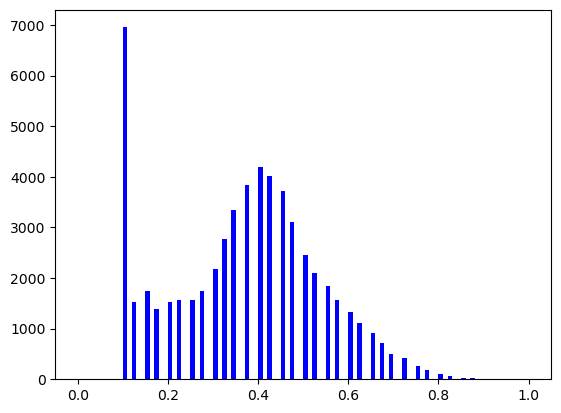

In [20]:
plt.hist(diversity_record_f, bins=100, range=(0,1.0), alpha=1, color='b')

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          32., 2792., 2137., 1626., 1113.,  926.,  740.,  704.,  697.,
         571.,  482.,  554.,  721.,  765.,  652.,  575.,  581.,  554.,
         527.,  548.,  472.,  704., 1034., 1089.,  959., 1624., 1929.,
        1518.,  995., 1105.,  984., 1884., 2532., 2787., 2223., 1990.,
        2660.,  863.,  954.,  925.,  773., 1128.,  649.,  886., 1073.,
         738.,  867.,  575.,  771.,  545.,  879.,  632.,  265.,  324.,
         483.,  304.,  429.,  133.,  149.,  313.,   25.,   71.,  256.,
           4.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29

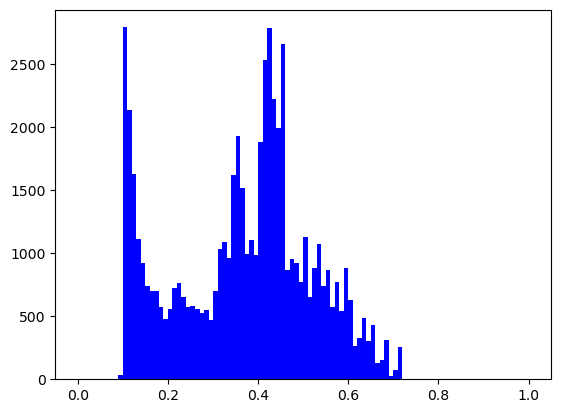

In [21]:
plt.hist(div_pri_f, bins=100, range=(0,1.0), alpha=1, color='b')

-0.026065607995565586
-0.005234761245102074


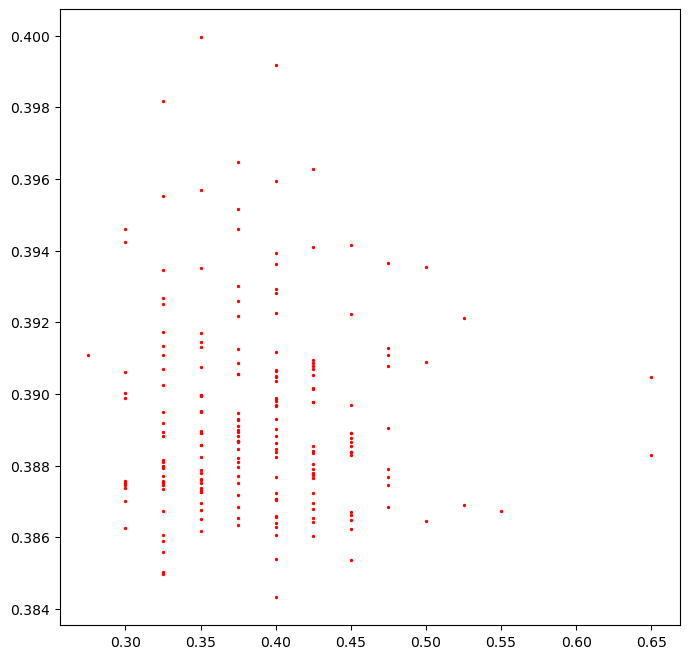

0.003419345634445399
0.04553958812473912


In [62]:
#计算相关系数和损失函数
start = 14600
end = 14800

plt.figure(figsize= (8,8))
plt.scatter(diversity_record_f[start:end],div_pri_f[start:end],  color = 'red', s= 2)
print(scipy.stats.pearsonr(diversity_record_f[start:end],div_pri_f[start:end])[0])
print(scipy.stats.spearmanr(diversity_record_f[start:end],div_pri_f[start:end], )[0])
plt.show()
#计算MSE
mse = np.mean((diversity_record_f[start:end] - div_pri_f[start:end]) ** 2)
mae = np.mean(np.abs(diversity_record_f[start:end] - div_pri_f[start:end]))
print(mse) 
print(mae)

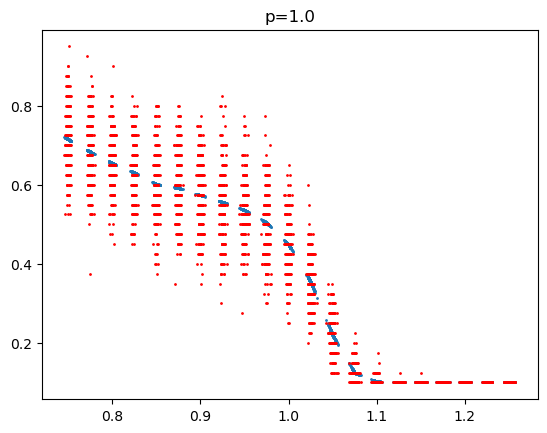

In [23]:
#p切片
p_index =13
start = p_index*4200
end = p_index*4200+4200
plt.figure()
plt.title('p={}'.format(ps[p_index]))
plt.scatter(AA_mean_f[start:end], div_pri_f[start:end],s=1)
plt.scatter(AA_mean_f[start:end], diversity_record_f[start:end], s=1 ,color ='red')
plt.show()





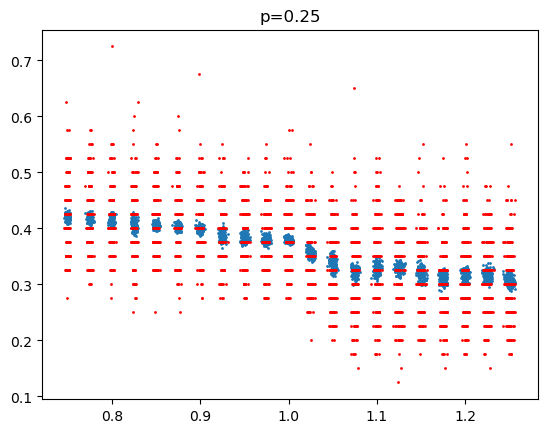

In [58]:
#p切片
p_index =0
start = p_index*4200
end = p_index*4200+4200
plt.figure()
plt.title('p={}'.format(ps[p_index]))
plt.scatter(AA_mean_f[start:end], div_pri_f[start:end],s=1)
plt.scatter(AA_mean_f[start:end], diversity_record_f[start:end], s=1 ,color ='red')
plt.show()

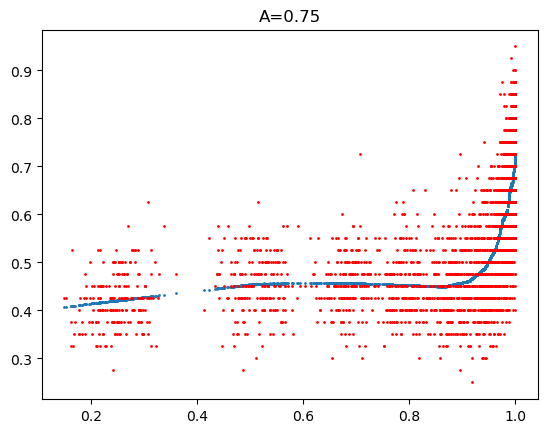

In [59]:
#a切片
a_index = 0
pp_cut = np.zeros(14*200)
div_pri_cut = np.zeros(14*200)
diversity_record_cut = np.zeros(14*200)

u=0
for i in range(14):
    for j in range(200):
        indices = i*4200+a_index*200+ j
        pp_cut[u] = pp_f[indices]
        div_pri_cut[u] = div_pri_f[indices]
        diversity_record_cut[u] = diversity_record_f[indices]
        u+=1

plt.figure()
plt.title('A={}'.format(A_mean[a_index]))
plt.scatter(pp_cut, div_pri_cut,s=1)
plt.scatter(pp_cut, diversity_record_cut, s=1 ,color ='red')
plt.show()

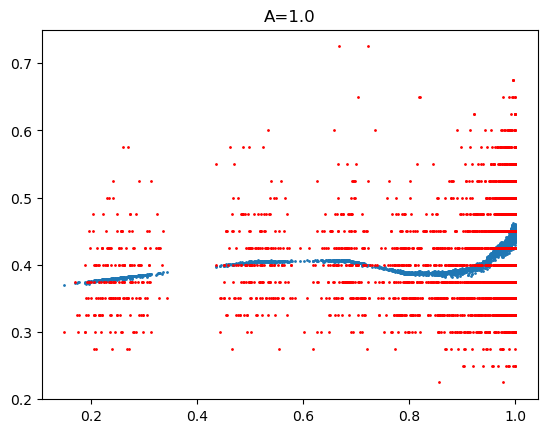

In [57]:
#a切片
a_index = 10
pp_cut = np.zeros(14*200)
div_pri_cut = np.zeros(14*200)
diversity_record_cut = np.zeros(14*200)

u=0
for i in range(14):
    for j in range(200):
        indices = i*4200+a_index*200+ j
        pp_cut[u] = pp_f[indices]
        div_pri_cut[u] = div_pri_f[indices]
        diversity_record_cut[u] = diversity_record_f[indices]
        u+=1

plt.figure()
plt.title('A={}'.format(A_mean[a_index]))
plt.scatter(pp_cut, div_pri_cut,s=1)
plt.scatter(pp_cut, diversity_record_cut, s=1 ,color ='red')
plt.show()

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 190.,
        562., 426., 218., 123.,  44.,  32.,   5.,   0.,   1.,   7.,  43.,
         80.,  42.,  20.,   7.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,
         19.,  49.,  86.,  39.,   3.,   0.,   0.,   0.,   3.,  37.,  66.,
         53.,  41.,  16.,  77.,  85.,  69., 133.,  72., 156., 132., 128.,
        134.,  94., 131., 125., 130.,  84.,  79.,  53.,  71.,  78.,  51.,
         34.,  29.,  20.,   6.,   8.,   5.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.

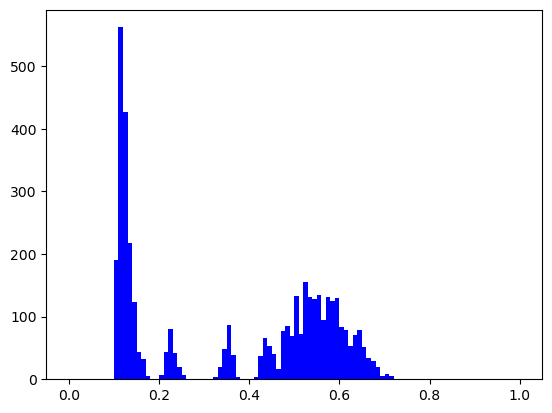

In [30]:
plt.hist(div_pri_f[start:end], bins=100, range=(0,1.0), alpha=1, color='b')


(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 1016.,    0.,  191.,    0.,    0.,  212.,    0.,  125.,
           0.,    0.,   85.,    0.,   68.,    0.,    0.,   66.,    0.,
          54.,    0.,    0.,   45.,    0.,   60.,    0.,   71.,    0.,
           0.,   70.,    0.,    0.,  114.,    0.,  125.,    0.,    0.,
         163.,    0.,  156.,    0.,    0.,  185.,    0.,  178.,    0.,
           0.,  212.,    0.,  183.,    0.,    0.,  189.,    0.,  147.,
           0.,    0.,  146.,    0.,   99.,    0.,   83.,    0.,    0.,
          66.,    0.,    0.,   40.,    0.,   24.,    0.,    0.,   14.,
           0.,    4.,    0.,    0.,    9.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29

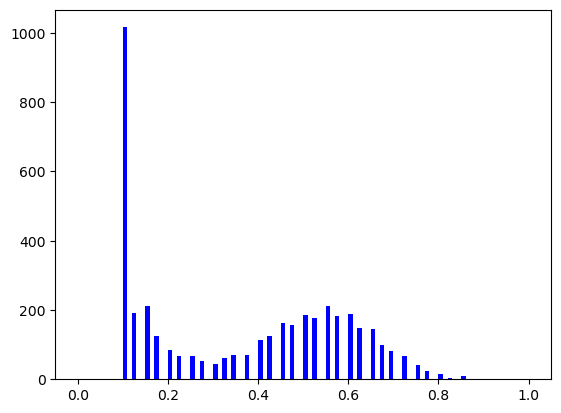

In [31]:

plt.hist(diversity_record_f[start:end], bins=100, range=(0,1.0), alpha=1, color='b')

In [32]:
@jit(nopython=True)
def LV_compute( AA,A_m):
    S=40
    N_mean = 0.5
    NN = np.zeros((T, S))
    r = np.ones(S)
    
    N0 = np.ones(S)*N_mean
    NN[0] = N0
    Migra = np.ones(S) * D
    
    for i in range(1, T):
        
        k1 = r * NN[i-1] * (1- np.dot(AA, NN[i-1]))* step
        k2 = r * (NN[i-1]+k1/2) * (1- np.dot(AA, NN[i-1]+k1/2))*step
        k3 = r * (NN[i-1]+k2/2) * (1- np.dot(AA, NN[i-1]+k2/2))*step
        k4 = r * (NN[i-1]+k3) * (1- np.dot(AA, NN[i-1]+k3))*step
        #NN[i] = NN[i-1] + r * NN[i-1] * (1- np.dot(AA, NN[i-1])) * step
        NN[i] = NN[i-1]+ (k1+2*k2+2*k3+k4)/6
        NN[i] += Migra  # 添加迁移
        
    return NN

In [33]:
@jit(nopython=True)
def axis_of_cols(matrix, num_cols):
    maxc = np.zeros(num_cols)
    livings=np.zeros(num_cols)
    flucc= np.zeros(num_cols)
    matrix_2 = matrix.T
    richness =0
    
    for i in range(num_cols):       
        maxc[i] =  np.max(matrix_2[i])
        if maxc[i]> abundance_threshold:
            livings[i] = 1
            richness+=1
            mean_v = np.mean(matrix_2[i])
            if mean_v!=0 and not np.isnan(np.std(matrix_2[i]) /mean_v):
                flucc[i] = np.std(matrix_2[i]) /mean_v

    return  richness, flucc, livings

In [34]:

r_mean = 1.0  # 平均增长率
S = 40
D = 1e-6  # 迁移率
A_mean_range = [0.75, 1.25]  # 平均抑制系数范围
ystep = 21  # A_mean 的步数
pstep = 14  # A_mean 的步数


T_real = 1000  # 总进化时间
step = 0.05  # 时间间隔
T = int(np.ceil(T_real / step))  # 循环次数
num_sim = 200  # 系综平均次数
period = 200  # 用于计算丰富度的持续时间
abundance_threshold = 1e-3  # 物种生存的丰度阈值

In [35]:
livings_record = np.load('livings_record_222.npy')

In [36]:
#测试稳定性
for in1 in range(14):
    for in2 in range(21):
        in3 =8
        AA = AA_s[in1,in2,in3]
        A_mean1= A_mean[in2]
        composition = LV_compute( AA, A_mean1 )
        richness,fluc_CV, livings1 = axis_of_cols(composition[T - period:T], 40)
        if richness/S != diversity_record[in1,in2,in3]:
            print('error')
        if np.sum(np.abs(livings1-livings_record[in1,in2,in3])) !=0:
            print('error')

In [37]:
in1 =12
in2 = 9
in3 = 4
AA = AA_s[in1,in2,in3]
A_mean1= A_mean[in2]
composition = LV_compute( AA, A_mean1 )
richness,fluc_CV, livings1 = axis_of_cols(composition[T - period:T], 40)


print(richness/40)
print(diversity_record[in1,in2,in3])
print(np.sum(np.abs(livings1-livings_record[in1,in2,in3])))

0.6
0.6
0.0


In [38]:
AA_s_f = AA_s.reshape(-1,40,40)
Adj_f  = matrix_s.reshape(-1,40,40)
livs_f = livings_record.reshape(-1,40)


In [39]:
#测试稳定性
for in1 in range(200):
    print(in1)
    AA = AA_s_f[in1]
    A_mean1= 1.0
    composition = LV_compute( AA, A_mean1 )
    richness,fluc_CV, livings1 = axis_of_cols(composition[T - period:T], 40)
    if richness/S != diversity_record_f[in1]:
        print('error')
    if np.sum(np.abs(livings1-livs_f[in1])) !=0:
        print('error')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [69]:
print(AA_s.shape)
AA_s_cut = AA_s[:,0:11,:,:,:]
print(AA_s_cut.shape)

print(matrix_s.shape)
Adj_cut = matrix_s[:,0:11,:,:,:]
print(Adj_cut.shape)

print(livings_record.shape)
livs_cut = livings_record[:,0:11,:,:]
print(livs_cut.shape)

print(diversity_record.shape)
div_cut = diversity_record[:,0:11,:]
print(div_cut.shape)

(14, 21, 200, 40, 40)
(14, 11, 200, 40, 40)
(14, 21, 200, 40, 40)
(14, 11, 200, 40, 40)
(14, 21, 200, 40)
(14, 11, 200, 40)
(14, 21, 200)
(14, 11, 200)


In [72]:
AAcutf = AA_s_cut.reshape(-1,40,40)
print(AAcutf.shape)
Adjcutf= Adj_cut.reshape(-1,40,40)
print(Adjcutf.shape)
livscutf=livs_cut.reshape(-1,40)
print(livscutf.shape)
divcutf = div_cut.flatten()
print(divcutf.shape)

(30800, 40, 40)
(30800, 40, 40)
(30800, 40)
(30800,)


In [73]:
indices = np.random.permutation(30800)
AA_data = AAcutf[indices]
Adj_data= Adjcutf[indices]
livs_data=livscutf[indices]
diversity_record_data = divcutf[indices]

In [75]:
#测试稳定性
for in1 in range(200):
    #print(in1)
    AA = AA_data[in1]
    A_mean1= 1.0
    composition = LV_compute( AA, A_mean1 )
    richness,fluc_CV, livings1 = axis_of_cols(composition[T - period:T], 40)
    if richness/S != diversity_record_data[in1]:
        print('error')
    if np.sum(np.abs(livings1-livs_data[in1])) !=0:
        print('error')

In [76]:
np.save('edges.npy', AA_data)
np.save('adj.npy',np.abs(Adj_data))
np.save('labels.npy', livs_data)
np.save('labels2.npy',diversity_record_data)